# Optimizing BIke AllocatIons Problem - Problem Solution

#### Mustafa Kerem Bulut - 150220303
#### Ömer Faruk San - 150220307
#### Abdullah Vefa Yankın - 150220318

In [1]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display

In [2]:
stations_df = pd.read_csv('station_capacities.csv')
stations_df.set_index('station_code', inplace=True)
capacities = stations_df['station_capacity'].to_dict()

In [4]:
daily_usage_df = pd.read_csv('station_daily_average_usage_data.csv')
daily_usage_df.set_index('station_code', inplace=True)
daily_usage_df['avg_flow'] = (daily_usage_df['avg_return'] - daily_usage_df['avg_rental'])

## 1. Minimizing Total Dissatisfaction in a Month


In [5]:
prob = pulp.LpProblem("Bike_Allocation_Optimization", pulp.LpMinimize)
initial_bikes = {}
overflow = {}
underflow = {}
total_cost = []

overflow_weight = 1.0
underflow_weight = 1.5

for sid, row in daily_usage_df.iterrows():
    net_flow = 30 * row['avg_flow'] # daily net flow to monthly net flow
    cap = capacities.get(sid, 0)
    I = pulp.LpVariable(f"I_{sid}", lowBound=0, upBound=cap, cat='Integer')
    x = pulp.LpVariable(f"x_{sid}", lowBound=0, cat='Continuous')
    y = pulp.LpVariable(f"y_{sid}", lowBound=0, cat='Continuous')

    initial_bikes[sid] = I
    overflow[sid] = x
    underflow[sid] = y

    a = I + net_flow

    prob += x >= a - cap, f"Overflow_{sid}"
    prob += x >= 0, f"NonNegativeOverflow_{sid}"
    prob += y >= -a, f"Underflow_{sid}"
    prob += y >= 0, f"NonNegativeUnderflow_{sid}"

    total_cost.append(overflow_weight * x + underflow_weight * y)

prob += pulp.lpSum(initial_bikes.values()) == 707, "TotalBikes"
prob += pulp.lpSum(total_cost)
prob.solve()

1

In [6]:
results = pd.DataFrame({
    'Station ID': list(initial_bikes.keys()),
    'Initial Bikes': [pulp.value(initial_bikes[sid]) for sid in initial_bikes],
    'Overflow': [pulp.value(overflow[sid]) for sid in overflow],
    'Underflow': [pulp.value(underflow[sid]) for sid in underflow],
    'Capacity': [capacities.get(sid, None) for sid in initial_bikes]
})

usage_df_reset = daily_usage_df[['avg_flow']].reset_index()
results = results.merge(usage_df_reset, left_on='Station ID', right_on='station_code', how='left')

results['Final Bikes Estimate'] = results['Initial Bikes'] + 30 * results['avg_flow']

results

,Station ID,Initial Bikes,Overflow,Underflow,Capacity,station_code,avg_flow,Final Bikes Estimate
0,KON 1001,1.0,0.0,0.0,12,KON 1001,0.062780,2.883408
1,KON 1002,9.0,0.0,0.0,12,KON 1002,0.076233,11.286996
2,KON 1006,9.0,0.0,0.0,12,KON 1006,0.067265,11.017937
3,KON 1011,11.0,0.0,0.0,18,KON 1011,0.215247,17.457399
4,KON 1015,11.0,0.0,0.0,12,KON 1015,0.017937,11.538117
...,...,...,...,...,...,...,...,...
115,KON 2050,12.0,0.0,0.0,12,KON 2050,0.000000,12.000000
116,KON 2051,9.0,0.0,0.0,12,KON 2051,0.000000,9.000000
117,KON 2052,6.0,0.0,0.0,6,KON 2052,0.000000,6.000000
118,KON 2053,6.0,0.0,0.0,6,KON 2053,0.000000,6.000000


In [7]:
results.to_csv("optimized_initial_bike_counts_for_a_month.csv", index=False)

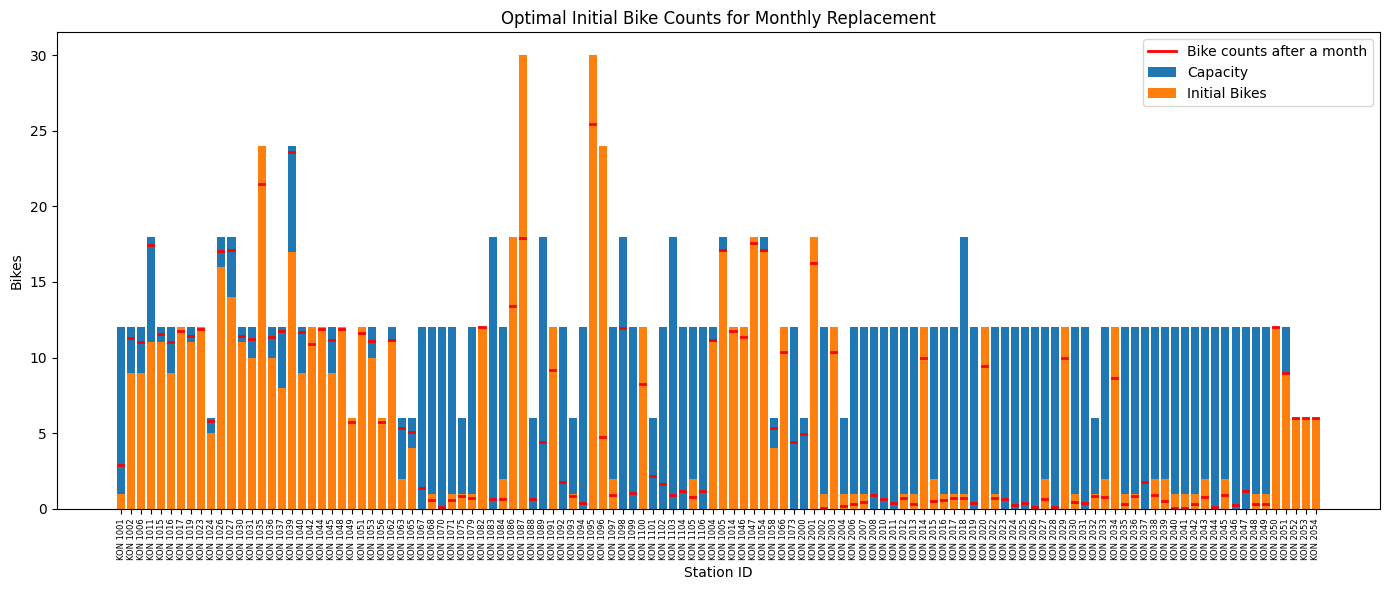

In [9]:
plt.figure(figsize=(14, 6))

plt.bar(results['Station ID'], results['Capacity'], label='Capacity', alpha=1)
plt.bar(results['Station ID'], results['Initial Bikes'], label='Initial Bikes', alpha=1)
x = results['Station ID']
initial = results['Initial Bikes']
final = results['Final Bikes Estimate']
capacity = results['Capacity']
x_pos = range(len(x))
for idx in x_pos:
    plt.plot(
        [idx - 0.3, idx + 0.2],
        [final[idx], final[idx]],
        color='red',
        linewidth=2,
        label='Bike counts after a month' if idx == 0 else ""
    )

plt.xlabel('Station ID')
plt.ylabel('Bikes')
plt.title("Optimal Initial Bike Counts for Monthly Replacement")
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Maximizing Total Days Without Dissatisfaction

In [10]:
prob = pulp.LpProblem("Maximize_Operational_Time", pulp.LpMaximize)

initial_bikes = {}
overflow = {}
underflow = {}
penalties = []

t = pulp.LpVariable("t", lowBound=0, cat='Continuous')

overflow_weight = 1.0
underflow_weight = 1.5

for sid, row in daily_usage_df.iterrows():
    flow = row['avg_flow']
    cap = capacities.get(sid, 0)

    I = pulp.LpVariable(f"I_{sid}", lowBound=0, upBound=cap, cat='Integer')
    x = pulp.LpVariable(f"x_{sid}", lowBound=0, cat='Continuous')  # Overflow
    y = pulp.LpVariable(f"y_{sid}", lowBound=0, cat='Continuous')  # Underflow

    initial_bikes[sid] = I
    overflow[sid] = x
    underflow[sid] = y

    a = I + t * flow

    if flow > 0:
        prob += x >= a - cap, f"Overflow_{sid}"
    elif flow < 0:
        prob += y >= -a, f"Underflow_{sid}"

    penalties.append(overflow_weight * x + underflow_weight * y)

prob += pulp.lpSum(initial_bikes.values()) == 707, "TotalBikes"

prob += t - pulp.lpSum(penalties)

prob.solve()

1

In [12]:
results = pd.DataFrame({
    'Station ID': list(initial_bikes.keys()),
    'Initial Bikes': [pulp.value(initial_bikes[sid]) for sid in initial_bikes],
    'Capacity': [capacities.get(sid, None) for sid in initial_bikes],
    'Net Flow': [daily_usage_df.loc[sid, 'avg_flow'] for sid in initial_bikes]
})

results['Time to Overflow/Empty'] = results.apply(
    lambda row: (row['Capacity'] - row['Initial Bikes']) / row['Net Flow'] if row['Net Flow'] > 0 else (
        row['Initial Bikes'] / abs(row['Net Flow']) if row['Net Flow'] < 0 else float('inf')
    ), axis=1
)

results['Time to Overflow/Empty'].min()


np.float64(36.162162162162154)

In [13]:
results.to_csv("optimized_initial_bikes_t_maximized.csv", index=False)

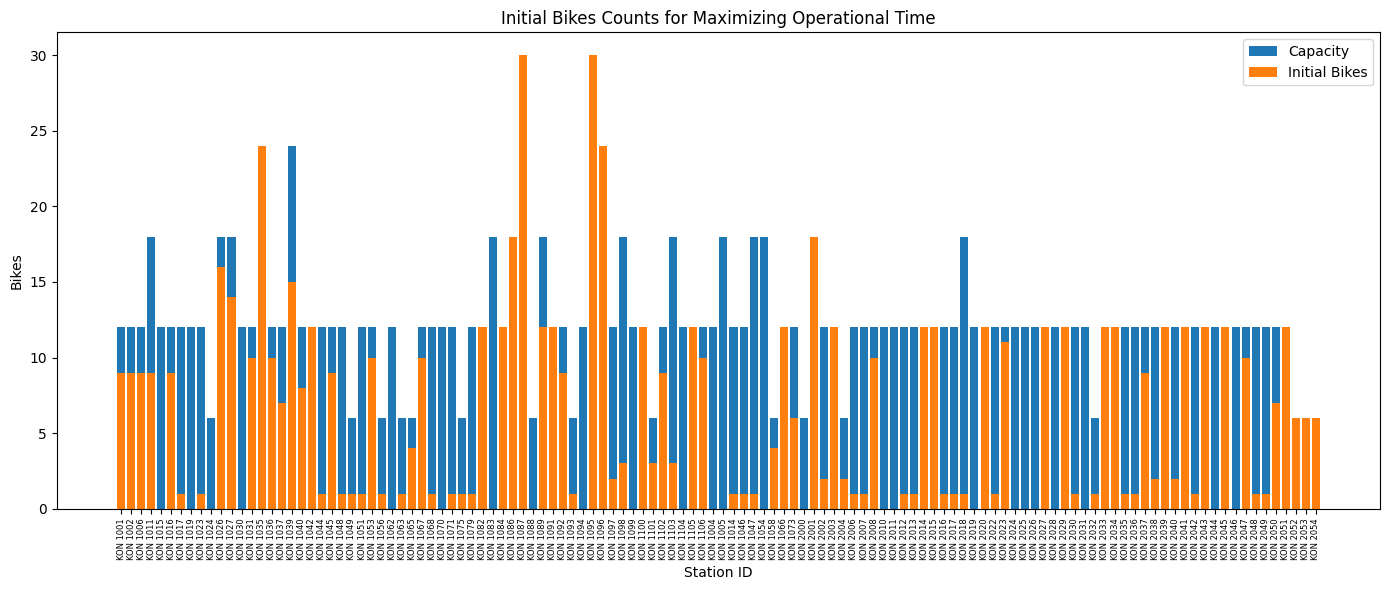

In [14]:
plt.figure(figsize=(14, 6))
plt.bar(results['Station ID'], results['Capacity'], label='Capacity', alpha=1)
plt.bar(results['Station ID'], results['Initial Bikes'], label='Initial Bikes')
plt.xlabel('Station ID')
plt.ylabel('Bikes')
plt.title('Initial Bikes Counts for Maximizing Operational Time')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()


##### Saving plots to create a gif

In [ ]:

df = pd.read_csv('optimized_initial_bikes_t_maximized.csv')
df.set_index('Station ID', inplace=True)

initial_bikes = df['Initial Bikes']
flow = df['Net Flow']
capacities = df['Capacity']
bike_counts = initial_bikes


for i in range(int(df['Time to Overflow/Empty'].min())):
    plt.figure(figsize=(14, 6))
    plt.bar(capacities.index, capacities.values, label='Station Capacity', alpha=1)
    plt.bar(bike_counts.index, bike_counts.values, label='Bike counts', alpha=1)
    plt.xlabel('Station ID')
    plt.ylabel('Number of Bikes')
    plt.title(f'Bike Counts After Day {i+1}')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'images/p2_{i+1}.png')
    plt.close()
    plt.clf()
    bike_counts += flow

<Figure size 640x480 with 0 Axes>

In [37]:
from PIL import Image
frames = []
i = 1
while True:
    try:
        img = Image.open(f'images/p2_{i}.png')
        frames.append(img)
        i += 1
    except FileNotFoundError:
        break

frames[0].save('plots/gif_p2.gif', format='GIF', append_images=frames[1:], save_all=True, duration=250, loop=0)

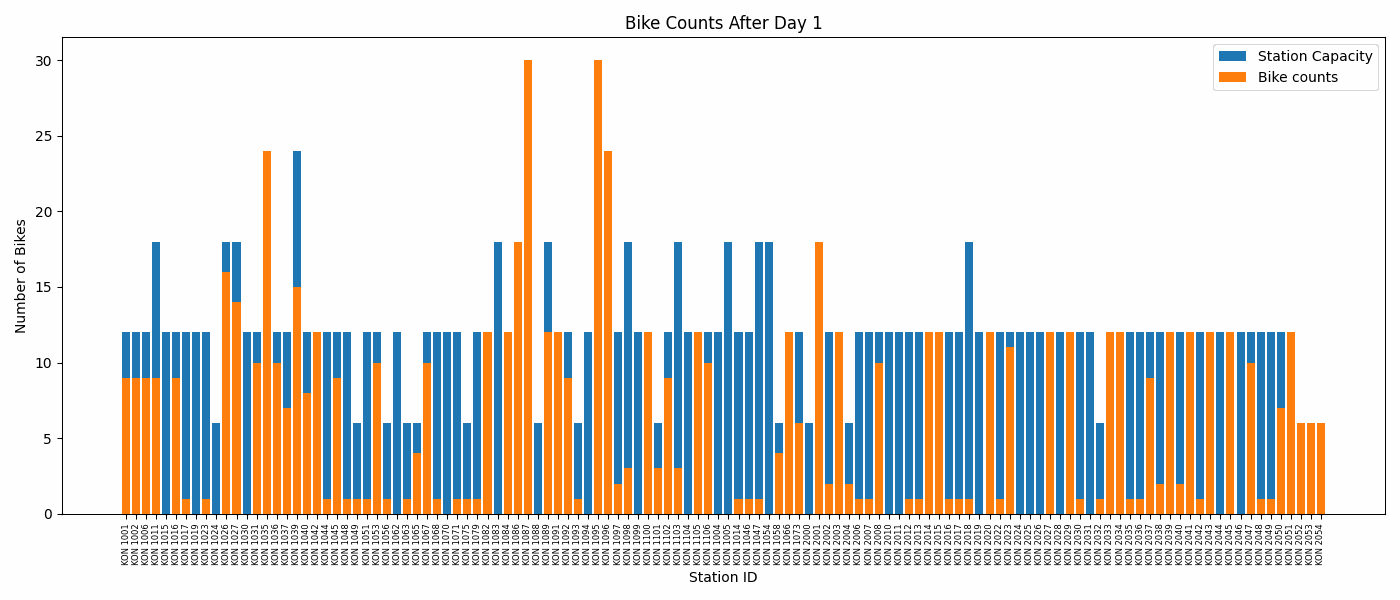

In [38]:
display(IPImage(filename='plots/gif_p2.gif'))

## 3. Maximizing Total Days Without Dissatisfaction With Balanced Initial Bike Counts

In [ ]:
prob = pulp.LpProblem("Maximize_Operational_Time", pulp.LpMaximize)

initial_bikes = {}
deviation_vars = []
overflow = {}
underflow = []
penalty_terms = []

t = pulp.LpVariable("t", lowBound=0, cat='Continuous')

deviation_weight = 0.001
overflow_weight = 1.0
underflow_weight = 1.5

for sid, row in daily_usage_df.iterrows():
    flow = row['avg_flow']
    cap = capacities.get(sid, 0)

    I = pulp.LpVariable(f"I_{sid}", lowBound=0, upBound=cap, cat='Integer')
    D = pulp.LpVariable(f"D_{sid}", lowBound=0, cat='Continuous')
    x = pulp.LpVariable(f"x_{sid}", lowBound=0, cat='Continuous')  # Overflow
    y = pulp.LpVariable(f"y_{sid}", lowBound=0, cat='Continuous')  # Underflow

    initial_bikes[sid] = I
    deviation_vars.append(D)
    overflow[sid] = x
    underflow.append(y)

    prob += I - 0.5 * cap <= D, f"DevPos_{sid}"
    prob += 0.5 * cap - I <= D, f"DevNeg_{sid}"

    a = I + t * flow

    if flow > 0:
        prob += x >= a - cap, f"Overflow_{sid}"
    elif flow < 0:
        prob += y >= -a, f"Underflow_{sid}"

    penalty_terms.append(deviation_weight * D + overflow_weight * x + underflow_weight * y)

prob += pulp.lpSum(initial_bikes.values()) == 707, "TotalBikes"

prob += t - pulp.lpSum(penalty_terms), "MaximizeTimeWithPenalty"

prob.solve()

1

In [29]:
results = pd.DataFrame({
    'Station ID': list(initial_bikes.keys()),
    'Initial Bikes': [pulp.value(initial_bikes[sid]) for sid in initial_bikes],
    'Capacity': [capacities.get(sid, None) for sid in initial_bikes],
    'Net Flow': [daily_usage_df.loc[sid, 'avg_flow'] for sid in initial_bikes]
})

results['Time to Overflow/Empty'] = results.apply(
    lambda row: (row['Capacity'] - row['Initial Bikes']) / row['Net Flow'] if row['Net Flow'] > 0 else (
        row['Initial Bikes'] / abs(row['Net Flow']) if row['Net Flow'] < 0 else float('inf')
    ), axis=1
)

results['Time to Overflow/Empty'].min()

np.float64(36.162162162162154)

In [30]:
results.to_csv("optimized_initial_bikes_t_maximized_balanced.csv", index=False)

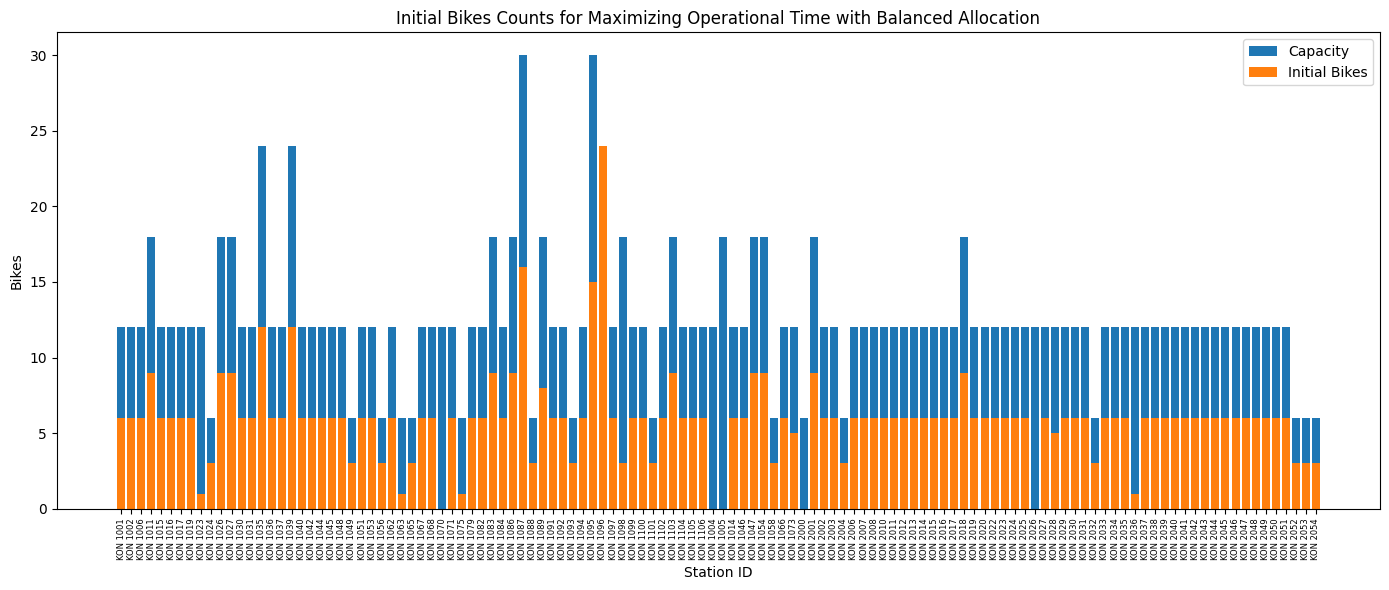

In [31]:
plt.figure(figsize=(14, 6))
plt.bar(results['Station ID'], results['Capacity'], label='Capacity', alpha=1)
plt.bar(results['Station ID'], results['Initial Bikes'], label='Initial Bikes')
plt.xlabel('Station ID')
plt.ylabel('Bikes')
plt.title('Initial Bikes Counts for Maximizing Operational Time with Balanced Allocation')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
df = pd.read_csv('optimized_initial_bikes_t_maximized_balanced.csv')
df.set_index('Station ID', inplace=True)

initial_bikes = df['Initial Bikes']
flow = df['Net Flow']
capacities = df['Capacity']
bike_counts = initial_bikes


for i in range(int(df['Time to Overflow/Empty'].min())):
    plt.figure(figsize=(14, 6))
    plt.bar(capacities.index, capacities.values, label='Station Capacity', alpha=1)
    plt.bar(bike_counts.index, bike_counts.values, label='Bike counts', alpha=1)
    plt.xlabel('Station ID')
    plt.ylabel('Number of Bikes')
    plt.title(f'Bike Counts After Day {i+1}')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'images/p3_{i+1}.png')
    plt.close()
    plt.clf()
    bike_counts += flow

<Figure size 640x480 with 0 Axes>

In [35]:
from PIL import Image
frames = []
i = 1
while True:
    try:
        img = Image.open(f'images/p3_{i}.png')
        frames.append(img)
        i += 1
    except FileNotFoundError:
        break

frames[0].save('plots/gif_p3.gif', format='GIF', append_images=frames[1:], save_all=True, duration=250, loop=0)

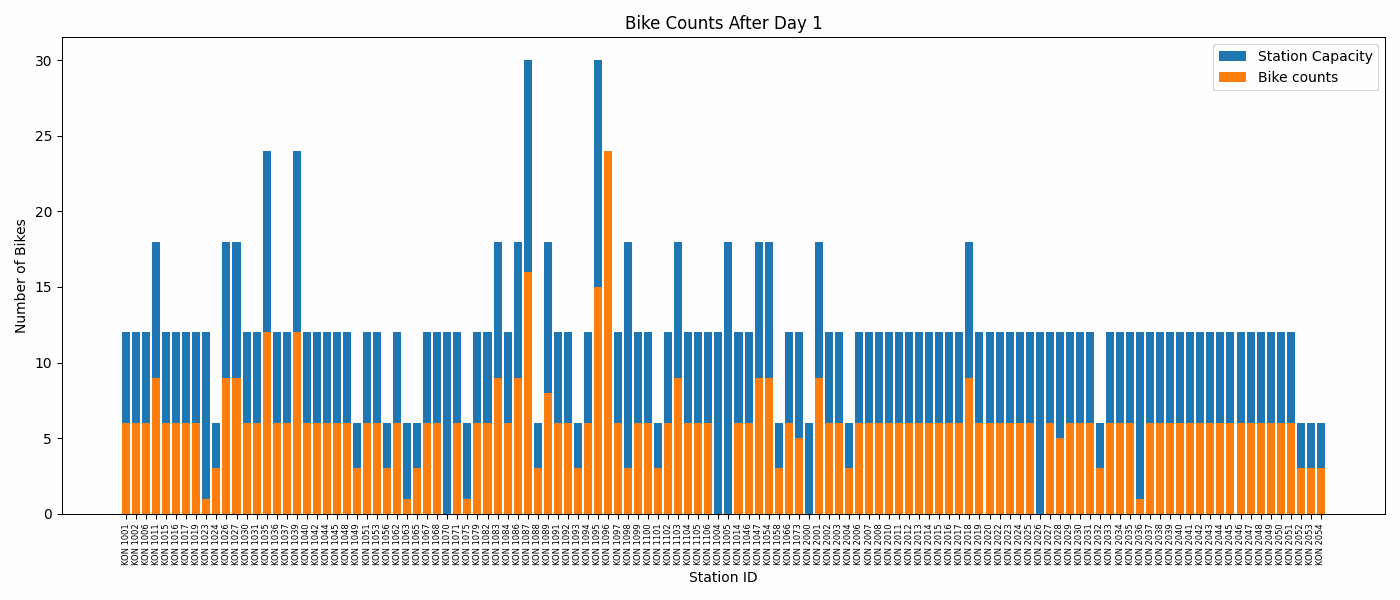

In [36]:
display(IPImage(filename='plots/gif_p3.gif'))